# Parallel parameter tuning

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

Then, let’s define a simple PyTorch model that we’ll be training. If you’re not familiar with PyTorch, the simplest way to define a model is to implement a nn.Module. This requires you to set up your model with `__init__` and then implement a forward pass. In this example we’re using a small convolutional neural network consisting of one 2D convolutional layer, a fully connected layer, and a softmax function.



In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Below, we have implemented functions for training and evaluating your Pytorch model. We define a train and a test function for that purpose. If you know how to do this, skip ahead to the next section.



In [3]:

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

Below we set up our main function to tune

In [8]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

Before start the tuning, let connect to the remote cluster and set up the runtime env.

Let's set up a remote cluster we use for the distributed training

```bash
~/kubectl apply -f ray-cluster.yaml
```

This is going to start a cluster with 2 workers and support auto-scaling.

To verify the cluster is acutally running

In [4]:
!~/kubectl get rayclusters

NAME              STATUS    RESTARTS   AGE
example-cluster   Running   0          118m


In [6]:
import ray

url = "ray://example-cluster-ray-head:10001"

env = {
    "pip": "requirements-env.txt"
}

context = ray.init(url, runtime_env=env)

The trials are going to run in parallel on the remote cluster

In [9]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

analysis = tune.run(train_mnist, config=search_space)

(run pid=2581) 2022-07-06 17:18:48,857	WARNING function_runner.py:604 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


(run pid=2581) == Status ==
(run pid=2581) Current time: 2022-07-06 17:18:54 (running for 00:00:05.62)
(run pid=2581) Memory usage on this node: 5.3/119.9 GiB
(run pid=2581) Using FIFO scheduling algorithm.
(run pid=2581) Resources requested: 1.0/9 CPUs, 0/0 GPUs, 0.0/12.6 GiB heap, 0.0/5.23 GiB objects (0.0/5.0 accelerator_type:M60)
(run pid=2581) Result logdir: /home/ray/ray_results/train_mnist_2022-07-06_17-18-48
(run pid=2581) Number of trials: 1/1 (1 RUNNING)
(run pid=2581) +-------------------------+----------+------------------+------------+------------+
(run pid=2581) | Trial name              | status   | loc              |         lr |   momentum |
(run pid=2581) |-------------------------+----------+------------------+------------+------------|
(run pid=2581) | train_mnist_5f5b3_00000 | RUNNING  | 10.10.68.44:2717 | 0.00014011 |   0.264068 |
(run pid=2581) +-------------------------+----------+------------------+------------+------------+
(run pid=2581) 
(run pid=2581) 
(tra

  6%|▌         | 557056/9912422 [00:00<00:01, 5525745.94it/s]


(train_mnist pid=2717) Extracting /home/ray/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/ray/data/MNIST/raw


100%|██████████| 9912422/9912422 [00:00<00:00, 37786311.04it/s]


(train_mnist pid=2717) 
(train_mnist pid=2717) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(train_mnist pid=2717) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /home/ray/data/MNIST/raw/train-labels-idx1-ubyte.gz
(train_mnist pid=2717) Extracting /home/ray/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/ray/data/MNIST/raw
(train_mnist pid=2717) 
(train_mnist pid=2717) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(train_mnist pid=2717) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /home/ray/data/MNIST/raw/t10k-images-idx3-ubyte.gz


100%|██████████| 1648877/1648877 [00:00<00:00, 4277200.73it/s]


(train_mnist pid=2717) Extracting /home/ray/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/ray/data/MNIST/raw
(train_mnist pid=2717) 
(train_mnist pid=2717) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(train_mnist pid=2717) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /home/ray/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(train_mnist pid=2717) Extracting /home/ray/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/ray/data/MNIST/raw
(train_mnist pid=2717) 


100%|██████████| 4542/4542 [00:00<00:00, 27450329.64it/s]


(run pid=2581) Result for train_mnist_5f5b3_00000:
(run pid=2581)   date: 2022-07-06_17-18-57
(run pid=2581)   done: false
(run pid=2581)   experiment_id: 305397e07dd74cd3bcb8b0df54fda716
(run pid=2581)   hostname: example-cluster-ray-head-type-n9flv
(run pid=2581)   iterations_since_restore: 1
(run pid=2581)   mean_accuracy: 0.096875
(run pid=2581)   node_ip: 10.10.68.44
(run pid=2581)   pid: 2717
(run pid=2581)   time_since_restore: 2.4670302867889404
(run pid=2581)   time_this_iter_s: 2.4670302867889404
(run pid=2581)   time_total_s: 2.4670302867889404
(run pid=2581)   timestamp: 1657153137
(run pid=2581)   timesteps_since_restore: 0
(run pid=2581)   training_iteration: 1
(run pid=2581)   trial_id: 5f5b3_00000
(run pid=2581)   warmup_time: 0.0036034584045410156
(run pid=2581)   
(run pid=2581) == Status ==
(run pid=2581) Current time: 2022-07-06 17:18:57 (running for 00:00:08.09)
(run pid=2581) Memory usage on this node: 5.4/119.9 GiB
(run pid=2581) Using FIFO scheduling algorithm.


(run pid=2581) 2022-07-06 17:19:00,506	INFO tune.py:748 -- Total run time: 11.75 seconds (11.43 seconds for the tuning loop).


[<AxesSubplot:>]

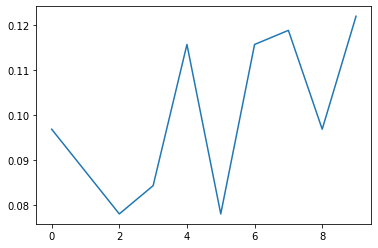

In [10]:
dfs = analysis.trial_dataframes
[d.mean_accuracy.plot() for d in dfs.values()]

We can use a different scheduler to terminate early smartly.

In [11]:
analysis = tune.run(
    train_mnist,
    num_samples=20,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space,
)

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = analysis.trial_dataframes

(run pid=2581) == Status ==
(run pid=2581) Current time: 2022-07-06 17:20:22 (running for 00:00:05.42)
(run pid=2581) Memory usage on this node: 5.4/119.9 GiB
(run pid=2581) Using AsyncHyperBand: num_stopped=0
(run pid=2581) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
(run pid=2581) Resources requested: 1.0/9 CPUs, 0/0 GPUs, 0.0/12.6 GiB heap, 0.0/5.23 GiB objects (0.0/5.0 accelerator_type:M60)
(run pid=2581) Result logdir: /home/ray/ray_results/train_mnist_2022-07-06_17-20-17
(run pid=2581) Number of trials: 16/20 (15 PENDING, 1 RUNNING)
(run pid=2581) +-------------------------+----------+------------------+-------------+------------+
(run pid=2581) | Trial name              | status   | loc              |          lr |   momentum |
(run pid=2581) |-------------------------+----------+------------------+-------------+------------|
(run pid=2581) | train_mnist_94102_00000 | RUNNING  | 10.10.68.44:3002 | 2.06501e-06 |   0.505825 |
(run pid=2581)

(run pid=2581) 2022-07-06 17:20:44,415	INFO tune.py:748 -- Total run time: 27.12 seconds (26.82 seconds for the tuning loop).


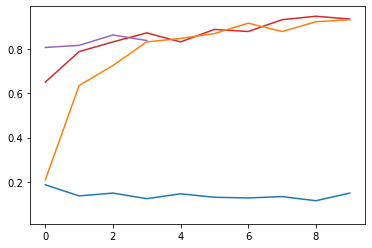

In [12]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)